In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import warnings
import tqdm
warnings.filterwarnings("ignore")

In [2]:
class ActivationNetwork:
    def __init__(self, N=70, alpha=2.2, lambda_=1.0, noise_std=0.03, dt=1, T=50, input_size = 5, input_level = 0.334):
        self.N = N
        self.alpha = alpha
        self.lambda_ = lambda_
        self.noise_std = noise_std
        self.dt = dt
        self.num_steps = T
        self.input_level = input_level
        self.input_size = input_size
        self.epsilon = 1e-8
    
    def F(self, x, type='rational sigmoid', threshold=0.2, slope=0.5):
        return x * slope
    
    def run_simulation(self, beta, set_size):
        x = np.zeros(self.N)
        # x = np.random.rand(self.N)
        x_t = np.zeros((self.num_steps, self.N))

        I = np.zeros(self.N)
        I[:set_size] = self.input_level

        for step in range(self.num_steps):
            if step >= self.input_size:
                I[:set_size] = 0

            for i in range(self.N):
                interaction_sum = np.sum(self.F(x[j]) for j in range(self.N) if j != i)
                # noise = 0
                noise = np.random.normal(0, self.noise_std)
                x[i] = max((1-self.dt) * x[i] + self.dt * (self.alpha * self.F(x[i]) - beta * interaction_sum + I[i] + noise), 0)
                # x[i] = (1-self.dt) * x[i] + self.dt * (self.alpha * self.F(x[i]) - beta * interaction_sum + I[i] + noise)
            x_t[step, :] = x

        # plt.plot(x_t)
        # plt.xlabel('Time Steps')
        # plt.ylabel('Activation Levels')
        # plt.title('Activation Levels Over Time')
        # plt.show()
        
        # print(x_t[-1])

        return np.mean(x_t[-1, :])
    
    def run_simulation_with_graph(self, beta, set_size):
        x = np.zeros(self.N)
        # x = np.random.rand(self.N)
        x_t = np.zeros((self.num_steps, self.N))

        I = np.zeros(self.N)
        I[:set_size] = self.input_level

        for step in range(self.num_steps):
            if step >= self.input_size:
                I[:set_size] = 0

            for i in range(self.N):
                interaction_sum = np.sum(self.F(x[j]) for j in range(self.N) if j != i)
                # noise = 0
                noise = np.random.normal(0, self.noise_std)
                x[i] = max((1-self.dt) * x[i] + self.dt * (self.alpha * self.F(x[i]) - beta * interaction_sum + I[i] + noise), 0)
                # x[i] = (1-self.dt) * x[i] + self.dt * (self.alpha * self.F(x[i]) - beta * interaction_sum + I[i] + noise)
            x_t[step, :] = x

        plt.plot(x_t)
        plt.xlabel('Time Steps')
        plt.ylabel('Activation Levels')
        plt.title('Activation Levels Over Time')
        plt.show()
        
        # print(x_t[-1])

        return np.mean(x_t[-1, :])
    
    def get_hamming_distance(self, beta, set_size):
        x = np.zeros(self.N)
        x_t = np.zeros((self.num_steps, self.N))
        I = np.zeros(self.N)
        I[:set_size] = self.input_level
        for step in range(self.num_steps):
            if step >= self.input_size:
                I[:set_size] = 0
            for i in range(self.N):
                interaction_sum = np.sum(self.F(x[j]) for j in range(self.N) if j != i)
                noise = np.random.normal(0, self.noise_std)
                x[i] = max((1-self.dt) * x[i] + self.dt * (self.alpha * self.F(x[i]) - beta * interaction_sum + I[i] + noise), 0)
            x_t[step, :] = x

        # plt.plot(x_t)
        # plt.xlabel('Time Steps')
        # plt.ylabel('Activation Levels')
        # plt.title('Activation Levels Over Time')
        # plt.show()
        
        # print(x_t[-1])
        
        I[:set_size] = self.input_level
        x_t = np.where(x_t > 0.1, 1, 0)
        I = np.where(I > 0.1, 1, 0)
        hamming_distance = np.sum(np.abs(I - x_t[-1, :]))
        return hamming_distance
    
    def get_rt(self, beta, set_size):
        x = np.zeros(self.N)
        x_t = np.zeros((self.num_steps, self.N))
        x_dot = np.zeros(self.N)
        I = np.zeros(self.N)
        I[:set_size] = self.input_level
        total_energy = 0
        total_reaction_time = 0
        for step in range(self.num_steps):
            if step >= self.input_size:
                I[:set_size] = 0
            dx = np.zeros(self.N)
            for i in range(self.N):
                interaction_sum = np.sum(self.F(x[j]) for j in range(self.N) if j != i)
                noise = np.random.normal(0, self.noise_std)
                x[i] = max((1-self.dt) * x[i] + self.dt * (self.alpha * self.F(x[i]) - beta * interaction_sum + I[i] + noise), 0)
                dx[i] = -self.lambda_ * x[i] + self.alpha * self.F(x[i]) - beta * interaction_sum + I[i] + noise
                x_dot[i] = dx[i] / self.dt
                fluctuation_energy = (1 - self.alpha * (self.F(x[i]) / x[i])**2) * x_dot[i]**2 if x[i] != 0 else 0
                total_energy += fluctuation_energy * self.dt
                total_reaction_time += fluctuation_energy * self.dt
            x_t[step, :] = x
        return np.mean(x_t[-1, :]), abs(total_energy), abs(total_reaction_time)

    def find_mean_activation(self, beta, set_size, num_simulations=100):
        avg_activation = 0
        for _ in range(num_simulations):
            avg_activation += self.run_simulation(beta, set_size) / num_simulations
        return avg_activation
    
    def find_mean_hamming_distance(self, beta, set_size, num_simulations=100):
        avg_activation = 0
        for _ in range(num_simulations):
            avg_activation += self.get_hamming_distance(beta, set_size) / num_simulations
        return avg_activation
    
    def find_prob_larger_response(self, beta, set_size, num_simulations=100, const_set_size=16, threshold=0.01):
        num_larger_responses = 0
        for _ in range(num_simulations):
            response1 = self.run_simulation(beta, set_size)
            response2 = self.run_simulation(beta, const_set_size)
            if response1 - response2 > threshold:
                num_larger_responses += 1
        return num_larger_responses / num_simulations
    
    def find_mean_rt(self, beta, set_size, num_simulations=100):
        avg_activation = 0
        avg_energy = 0
        avg_reaction_time = 0
        for _ in range(num_simulations):
            activation, energy, reaction_time = self.get_rt(beta, set_size)
            avg_activation += activation / num_simulations
            avg_energy += energy / num_simulations
            avg_reaction_time += reaction_time / num_simulations
        return avg_activation, avg_energy, avg_reaction_time

    def plot_mean_activation(self, betas, set_sizes, num_simulations=100):
        mean_activations = np.zeros((len(betas), len(set_sizes)))

        for i, beta in enumerate(betas):
            for j, set_size in enumerate(set_sizes):
                mean_activations[i, j] = self.find_mean_activation(beta, set_size, num_simulations)

        plt.figure(figsize=(12, 8))
        for i, beta in enumerate(betas):
            plt.plot(set_sizes, mean_activations[i, :], label=f'β = {beta}')
        
        plt.xlabel('Set Size (Number of Nodes Receiving Input)')
        plt.ylabel('Mean Steady-State Activation')
        plt.title('Mean Steady-State Activation vs Set Size for Different β Values')
        plt.legend()
        plt.show()

    def plot_mean_p(self, betas, set_sizes, num_simulations=100):
        mean_activations = np.zeros((len(betas), len(set_sizes)))

        for i, beta in enumerate(betas):
            for j, set_size in enumerate(set_sizes):
                mean_activations[i, j] = 1 - self.find_mean_hamming_distance(beta, set_size, num_simulations) / self.N

        plt.figure(figsize=(12, 8))
        for i, beta in enumerate(betas):
            plt.plot(set_sizes, mean_activations[i, :], label=f'β = {beta}')
        
        plt.xlabel('Set Size (Number of Nodes Receiving Input)')
        plt.ylabel('P(beta, set size)')
        plt.title('P(beta, set size) vs Set Size for Different β Values')
        plt.legend()
        plt.show()

    def plot_rt_vs_set_size_for_betas(self, betas, set_sizes, num_simulations=100):
        plt.figure(figsize=(10, 6))
        for beta in betas:
            rt_values = []
            for set_size in set_sizes:
                avg_rt = 0
                for _ in range(num_simulations):
                    _, _, rt = self.find_mean_rt(beta, set_size, num_simulations)
                    avg_rt += rt / num_simulations
                rt_values.append(np.log10(avg_rt + self.epsilon))

            plt.plot(set_sizes, rt_values, label=f'β = {beta}')
        plt.xlabel('Set Size (Number of Nodes Receiving Input)')
        plt.ylabel('log(RT)')
        plt.title('log(RT) vs Set Size for Different β Values')
        plt.legend()
        plt.show()

    def plot_probability_larger_response(self, betas, set_sizes, num_simulations=100, const_set_size=16, threshold=0.01):
        plt.figure(figsize=(10, 6))
        for beta in betas:
            prob_larger_responses = []
            for set_size in set_sizes:
                prob_larger_responses.append(self.find_prob_larger_response(beta, set_size, num_simulations, const_set_size, threshold))
            plt.plot(set_sizes / const_set_size, prob_larger_responses, label=f'β = {beta}')
        plt.xlabel('Set Size (Number of Nodes Receiving Input)')
        plt.ylabel('Probability of Larger Response')
        plt.title('Probability of Larger Response vs Set Size for Different β Values')
        plt.legend()
        plt.show()

    def plot_probability_smaller_response(self, betas, set_sizes, num_simulations=100, const_set_size=16, threshold=0.01):
        plt.figure(figsize=(10, 6))
        for beta in betas:
            prob_larger_responses = []
            for set_size in set_sizes:
                prob_larger_responses.append(1 - self.find_prob_larger_response(beta, set_size, num_simulations, const_set_size, threshold))
            plt.plot(set_sizes / const_set_size, prob_larger_responses, label=f'β = {beta}')
        plt.xlabel('Set Size (Number of Nodes Receiving Input)')
        plt.ylabel('Probability of Samller Response')
        plt.title('Probability of Smaller Response vs Set Size for Different β Values')
        plt.legend()
        plt.show()

    def average_probability_over_betas(self, betas, target_numerosities, const_numerosity=16, threshold=0.01, num_simulations=100):
        avg_probabilities = []
        for target_numerosity in target_numerosities:
            prob_sum = 0
            for beta in betas:
                prob_sum += self.find_prob_larger_response(beta, target_numerosity, num_simulations, const_numerosity, threshold)
            avg_probabilities.append(prob_sum / len(betas))
        return avg_probabilities
    
    def sigmoid(self, x, x0, k, L=1):
        return L / (1 + np.exp(-k * (x - x0)))

    def fit_sigmoid_and_calculate_weber_fraction(self, numerosity_ratios, avg_probabilities):
        popt, _ = curve_fit(self.sigmoid, numerosity_ratios, avg_probabilities, maxfev=10000)
        x0, k = popt[0], popt[1]
        weber_fraction = (x0 * (1 + 0.14)) - x0
        x_vals = np.linspace(min(numerosity_ratios), max(numerosity_ratios), 100)
        y_vals = self.sigmoid(x_vals, *popt)
        plt.figure(figsize=(10, 6))
        plt.plot(numerosity_ratios, avg_probabilities, 'o', label="Average Probabilities")
        plt.plot(x_vals, y_vals, label="Sigmoid Fit")
        plt.xlabel("Numerosity Ratio")
        plt.ylabel("Probability of Larger Response")
        plt.title(f"Sigmoid Fit with Weber Fraction: {weber_fraction:.2f}")
        plt.legend()
        plt.show()
        return weber_fraction
    
    def pairwise_discrimination_probability(self, betas, numerosities, num_simulations=100, threshold=0.01):
        distance_effect_matrix = np.zeros((len(numerosities), len(numerosities)))
        
        for beta in betas:
            for i in tqdm.tqdm(range(len(numerosities))):
                set_ref = numerosities[i]
                for j in range(len(numerosities)):
                    set_size = numerosities[j]
                    prob = 0
                    for k in range(num_simulations):
                        mean_x_ref = np.mean(self.run_simulation(beta, set_ref))
                        mean_x_m = np.mean(self.run_simulation(beta, set_size))
                        prob += int(abs(mean_x_m - mean_x_ref) > threshold) / 100
                        
                    distance_effect_matrix[i, j] += prob
                    
            distance_effect_matrix /= len(betas)
        return distance_effect_matrix
    
    def plot_discrimination_matrix(self, prob_matrix, numerosities):
        mirrored_matrix =np.flipud(prob_matrix)

        rev_set_ref_vals = list(reversed(numerosities))

        # Plot the mirrored matrix
        plt.imshow(mirrored_matrix, aspect='auto')
        plt.xticks(ticks=range(len(numerosities)), labels=numerosities)
        plt.yticks(ticks=range(len(numerosities)), labels=rev_set_ref_vals)
        plt.xlabel('Set Size')
        plt.ylabel('Reference Set Size')
        plt.title('Effect of Distance on Recall with Mirrored Image')
        plt.colorbar()
        plt.show()

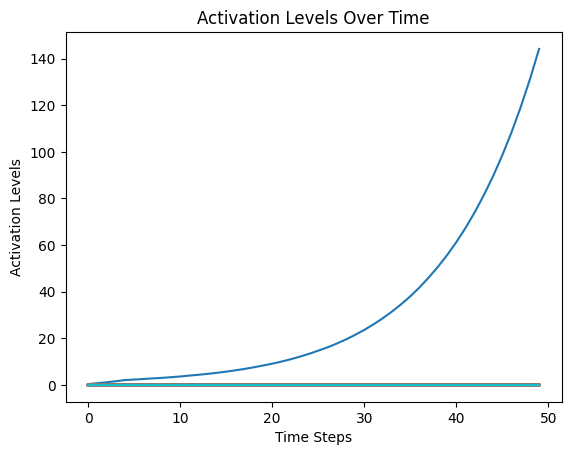

0


1.0

In [4]:
network = ActivationNetwork()
network.run_simulation_with_graph(0.1, 1)
print(network.get_hamming_distance(0.1, 1))
1-(network.get_hamming_distance(0.1, 1)/70)

In [5]:
network = ActivationNetwork(N=70, T=50, dt = 1, input_size=5)
network.run_simulation(0.1, 5)

0.3753855952590161

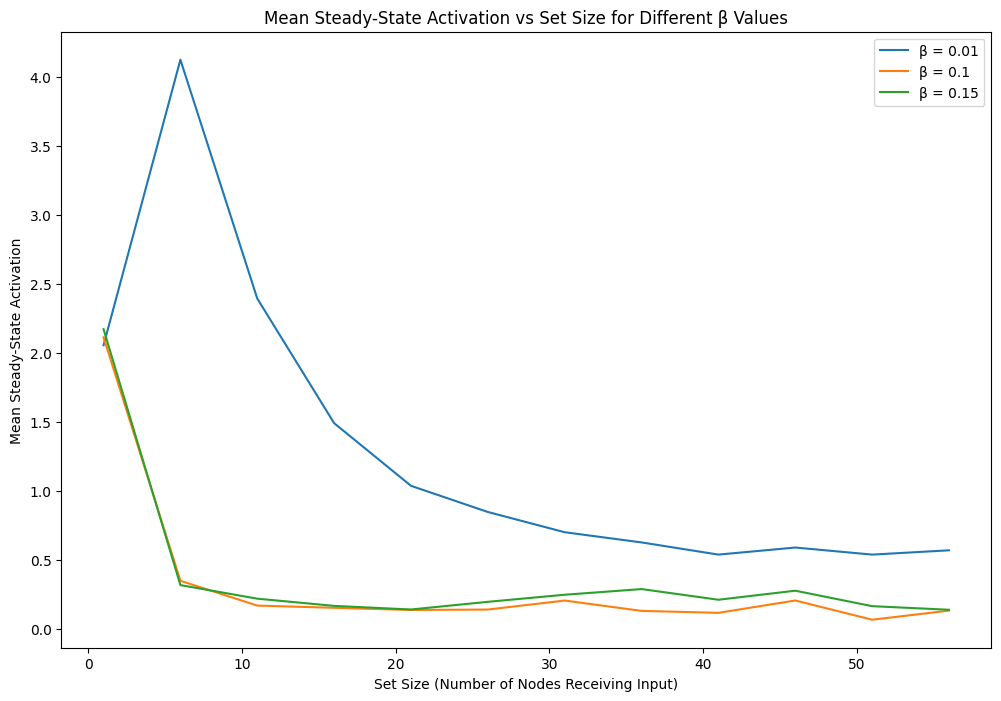

In [6]:
betas = [0.01, 0.1, 0.15]
set_sizes = np.arange(1, 61, 5)

network = ActivationNetwork()
network.plot_mean_activation(betas, set_sizes, num_simulations=5)

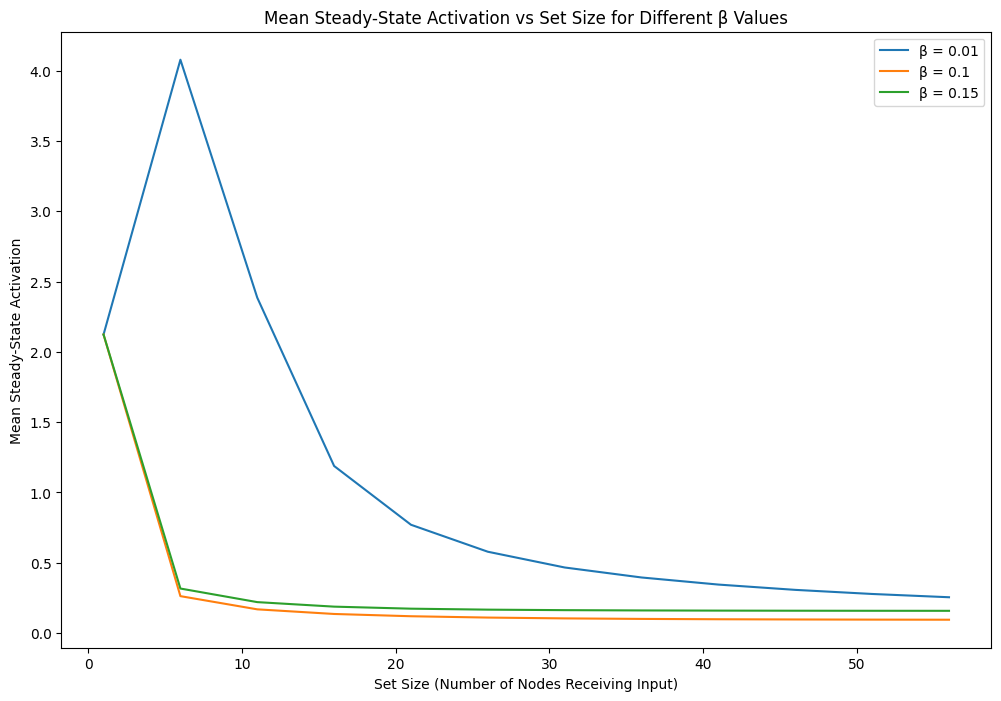

In [7]:
betas = [0.01, 0.1, 0.15]
set_sizes = np.arange(1, 61, 5)

network = ActivationNetwork(noise_std=0)
network.plot_mean_activation(betas, set_sizes, num_simulations=5)

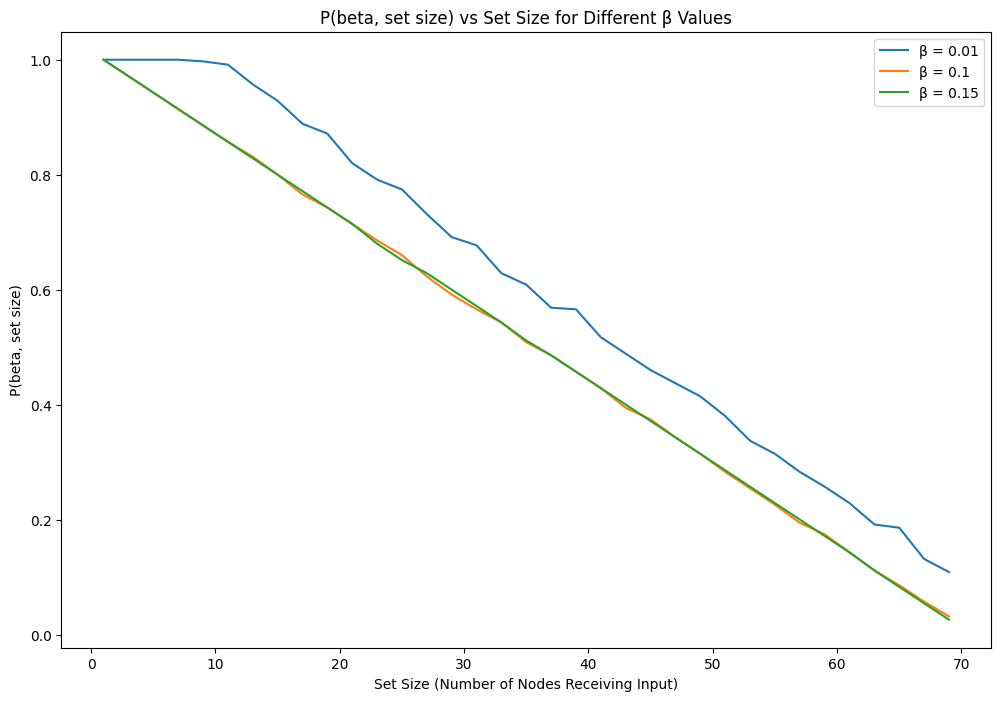

In [8]:
betas = [0.01, 0.1, 0.15]
set_sizes = np.arange(1, 71, 2)
network = ActivationNetwork()
network.plot_mean_p(betas, set_sizes, num_simulations=5)

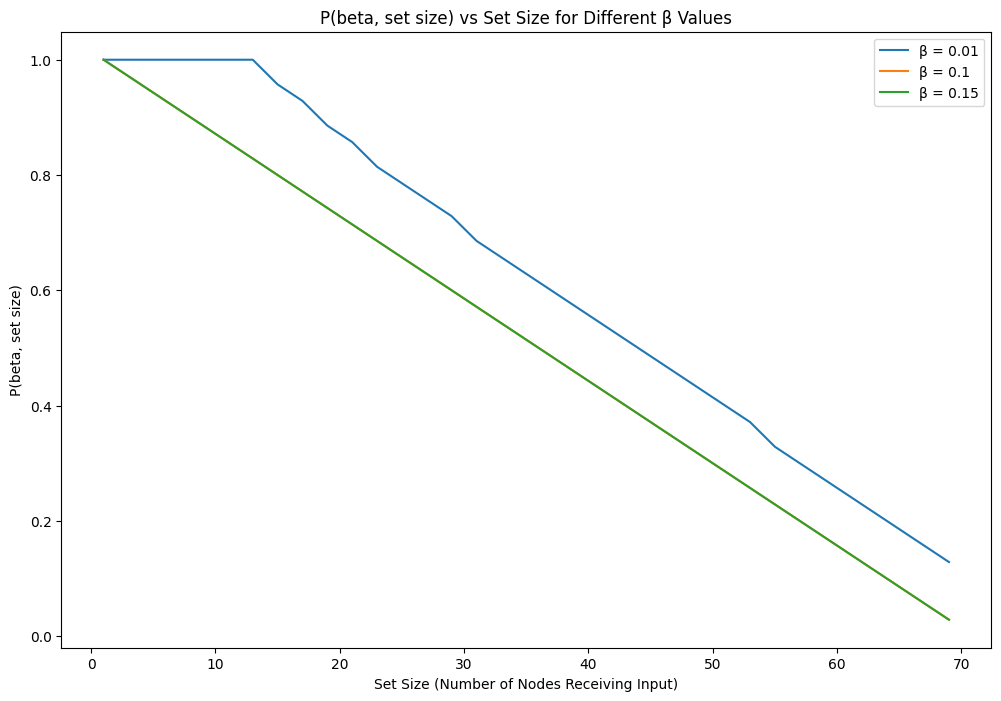

In [9]:
betas = [0.01, 0.1, 0.15]
set_sizes = np.arange(1, 71, 2)
network = ActivationNetwork(noise_std=0)
network.plot_mean_p(betas, set_sizes, num_simulations=5)

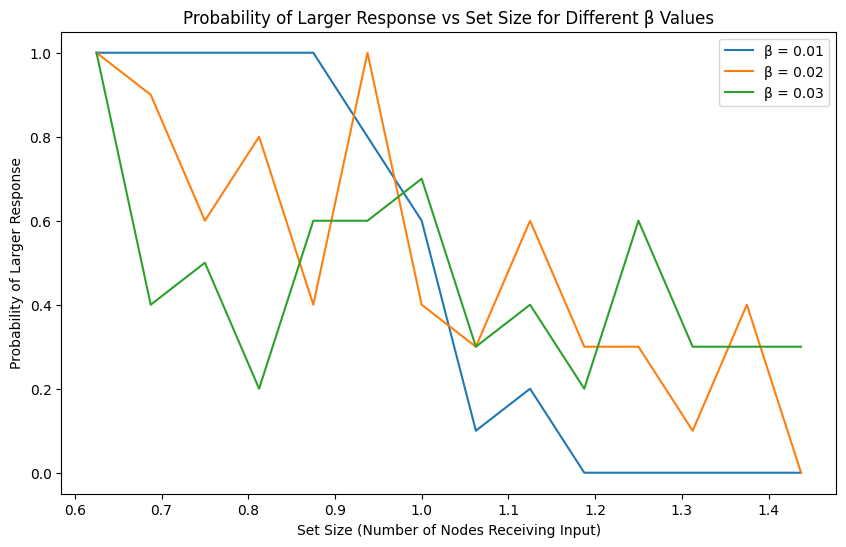

In [10]:
specific_betas = [0.01, 0.02, 0.03]
set_sizes = np.arange(10, 24)
network = ActivationNetwork()
network.plot_probability_larger_response(specific_betas, set_sizes, num_simulations=10)

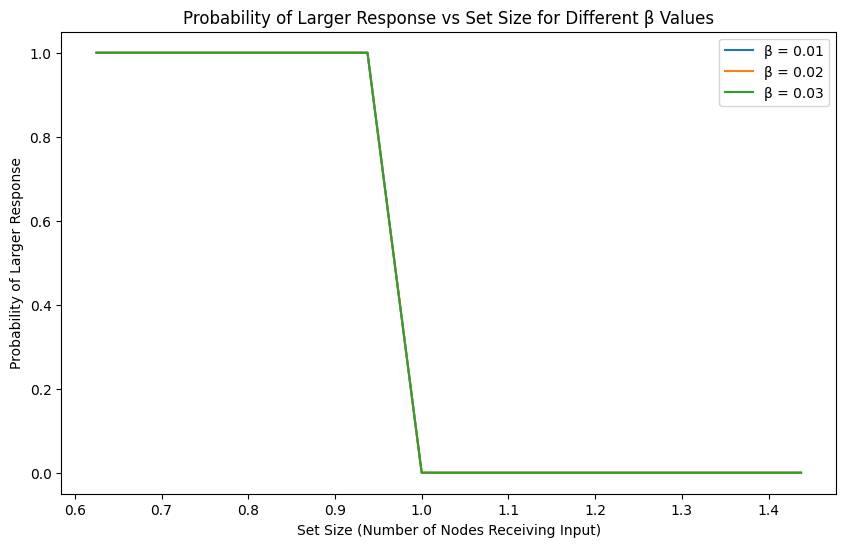

In [11]:
specific_betas = [0.01, 0.02, 0.03]
set_sizes = np.arange(10, 24)
network = ActivationNetwork(noise_std=0)
network.plot_probability_larger_response(specific_betas, set_sizes, num_simulations=10)

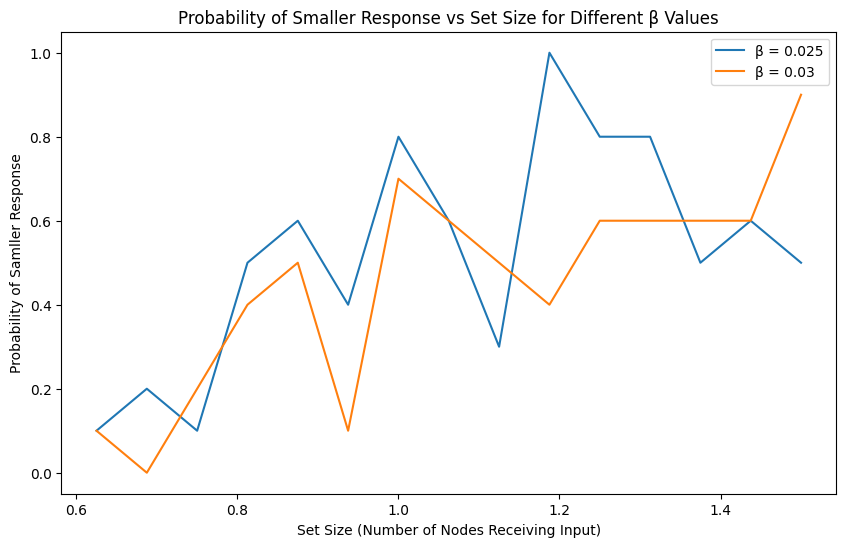

In [43]:
specific_betas = [0.025, 0.03]
set_sizes = np.arange(10, 25)
network = ActivationNetwork()
network.plot_probability_smaller_response(specific_betas, set_sizes, num_simulations=10)

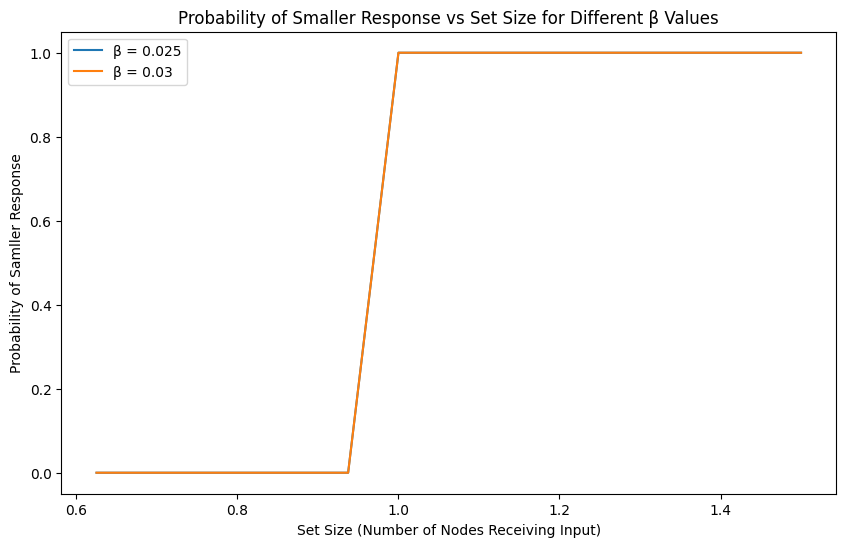

In [44]:
specific_betas = [0.025, 0.03]
set_sizes = np.arange(10, 25)
network = ActivationNetwork(noise_std=0)
network.plot_probability_smaller_response(specific_betas, set_sizes, num_simulations=10)

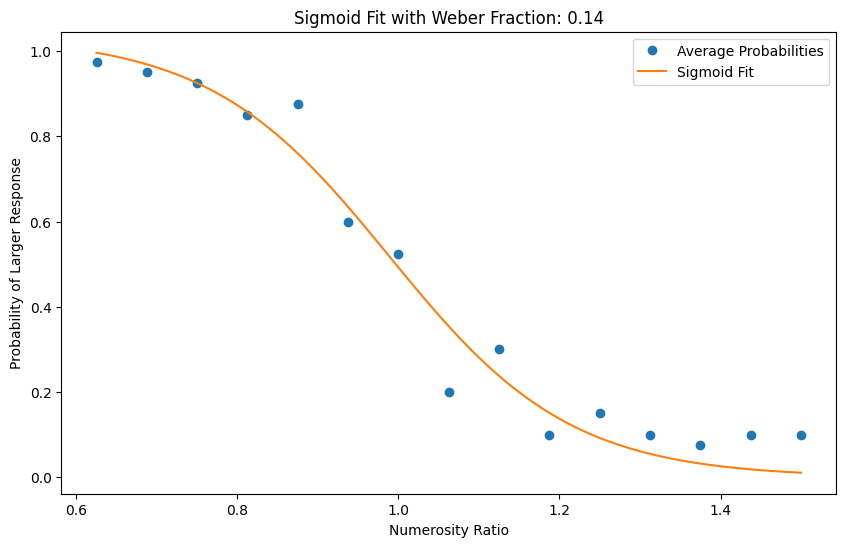

Calculated Weber Fraction: 0.13846866464499596


In [17]:
network = ActivationNetwork()
betas = [0.01, 0.011, 0.012, 0.03]
target_numerosities = np.arange(10, 25)
const_numerosity = 16
avg_probabilities = network.average_probability_over_betas(betas, target_numerosities, const_numerosity, num_simulations=10)
numerosity_ratios = target_numerosities / const_numerosity
weber_fraction = network.fit_sigmoid_and_calculate_weber_fraction(numerosity_ratios, avg_probabilities)
print(f"Calculated Weber Fraction: {weber_fraction}")

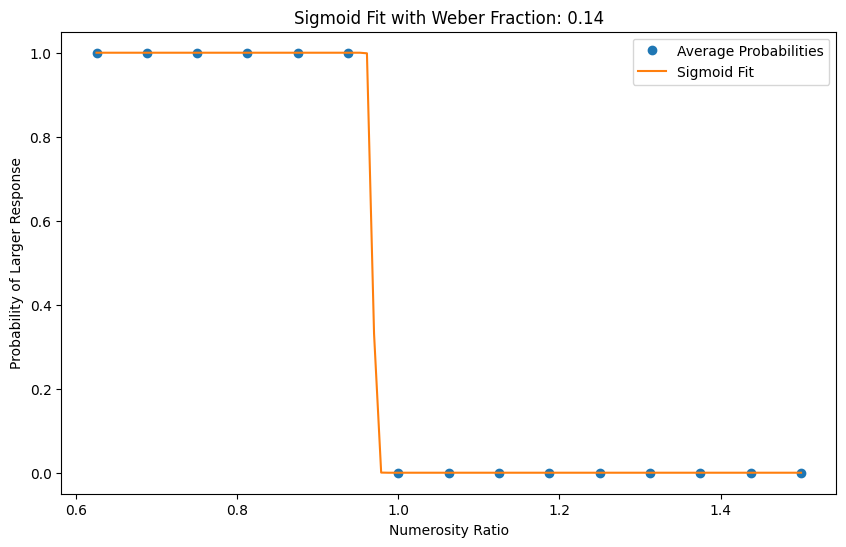

Calculated Weber Fraction: 0.1356381738378235


In [18]:
network = ActivationNetwork(noise_std=0)
betas = [0.01, 0.011, 0.012, 0.03]
target_numerosities = np.arange(10, 25)
const_numerosity = 16
avg_probabilities = network.average_probability_over_betas(betas, target_numerosities, const_numerosity, num_simulations=10)
numerosity_ratios = target_numerosities / const_numerosity
weber_fraction = network.fit_sigmoid_and_calculate_weber_fraction(numerosity_ratios, avg_probabilities)
print(f"Calculated Weber Fraction: {weber_fraction}")

100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


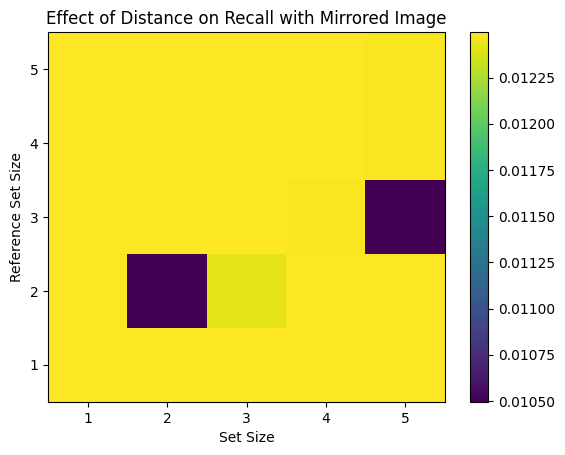

In [19]:
network = ActivationNetwork()
betas = [0.06, 0.08, 0.1, 0.14, 0.15]
numerosities = np.arange(1, 6)
prob_matrix = network.pairwise_discrimination_probability(betas, numerosities, num_simulations=5)
network.plot_discrimination_matrix(prob_matrix, numerosities)

In [20]:
prob_matrix

array([[0.012496 , 0.012496 , 0.012496 , 0.012496 , 0.012496 ],
       [0.012496 , 0.010496 , 0.012416 , 0.012496 , 0.012496 ],
       [0.012496 , 0.012496 , 0.012496 , 0.0124768, 0.010496 ],
       [0.012496 , 0.012496 , 0.012496 , 0.012496 , 0.01248  ],
       [0.012496 , 0.012496 , 0.012496 , 0.012496 , 0.01248  ]])

100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


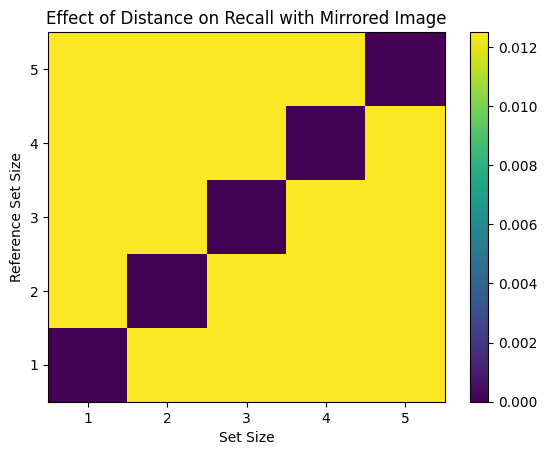

In [21]:
network = ActivationNetwork(noise_std=0)
betas = [0.06, 0.08, 0.1, 0.14, 0.15]
numerosities = np.arange(1, 6)
prob_matrix = network.pairwise_discrimination_probability(betas, numerosities, num_simulations=5)
network.plot_discrimination_matrix(prob_matrix, numerosities)

In [22]:
prob_matrix

array([[0.      , 0.012496, 0.012496, 0.012496, 0.012496],
       [0.012496, 0.      , 0.012496, 0.012496, 0.012496],
       [0.012496, 0.012496, 0.      , 0.012496, 0.012496],
       [0.012496, 0.012496, 0.012496, 0.      , 0.012496],
       [0.012496, 0.012496, 0.012496, 0.012496, 0.      ]])

# Ablations

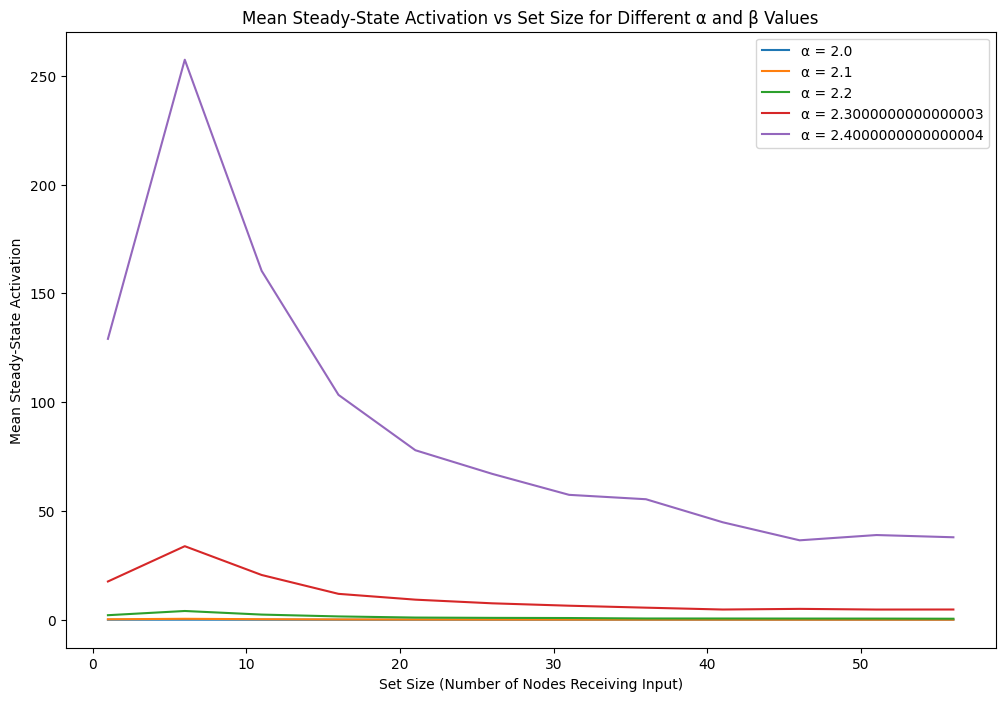

In [23]:
alphas = np.arange(2.0, 2.5, 0.1)
betas = [0.01]
set_sizes = np.arange(1, 61, 5)

plt.figure(figsize=(12, 8))

for alpha in alphas:
    network = ActivationNetwork(alpha=alpha)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=5)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'α = {alpha}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different α and β Values')
plt.legend()
plt.show()

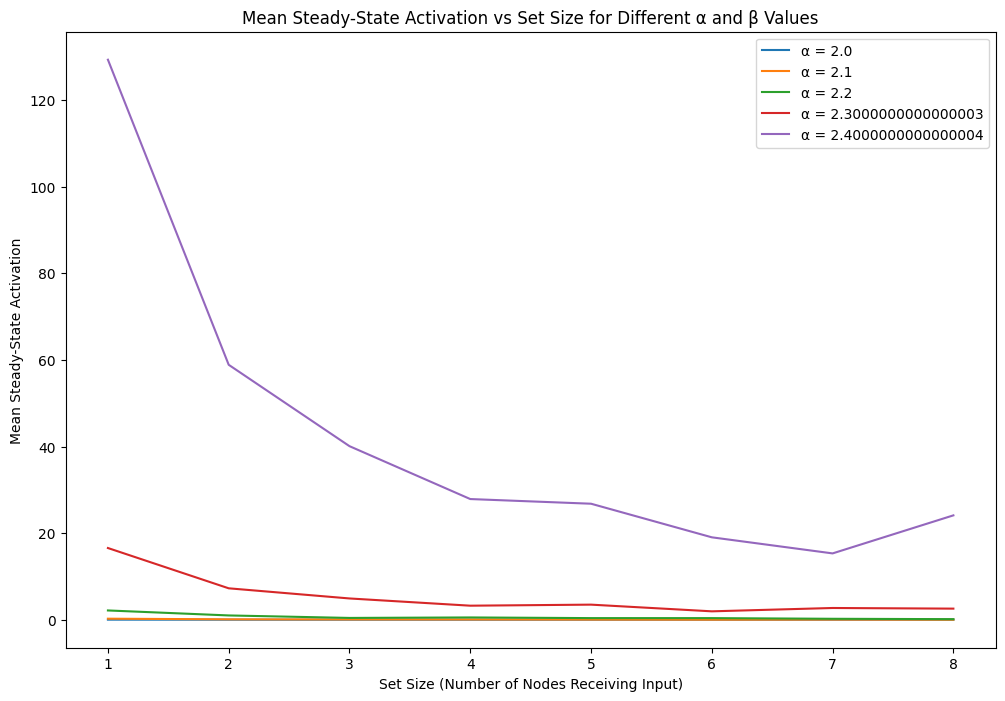

In [24]:
alphas = np.arange(2.0, 2.5, 0.1)
betas = [0.1]
set_sizes = np.arange(1, 9, 1)

plt.figure(figsize=(12, 8))

for alpha in alphas:
    network = ActivationNetwork(alpha=alpha)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=5)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'α = {alpha}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different α and β Values')
plt.legend()
plt.show()

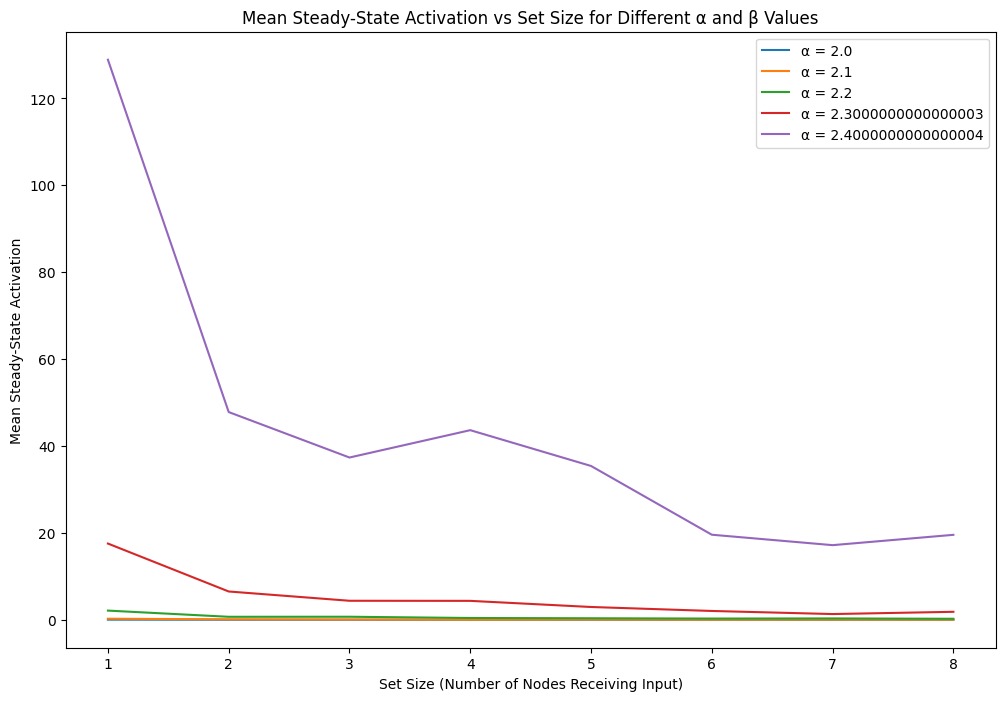

In [25]:
alphas = np.arange(2.0, 2.5, 0.1)
betas = [0.15]
set_sizes = np.arange(1, 9, 1)

plt.figure(figsize=(12, 8))

for alpha in alphas:
    network = ActivationNetwork(alpha=alpha)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=5)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'α = {alpha}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different α and β Values')
plt.legend()
plt.show()

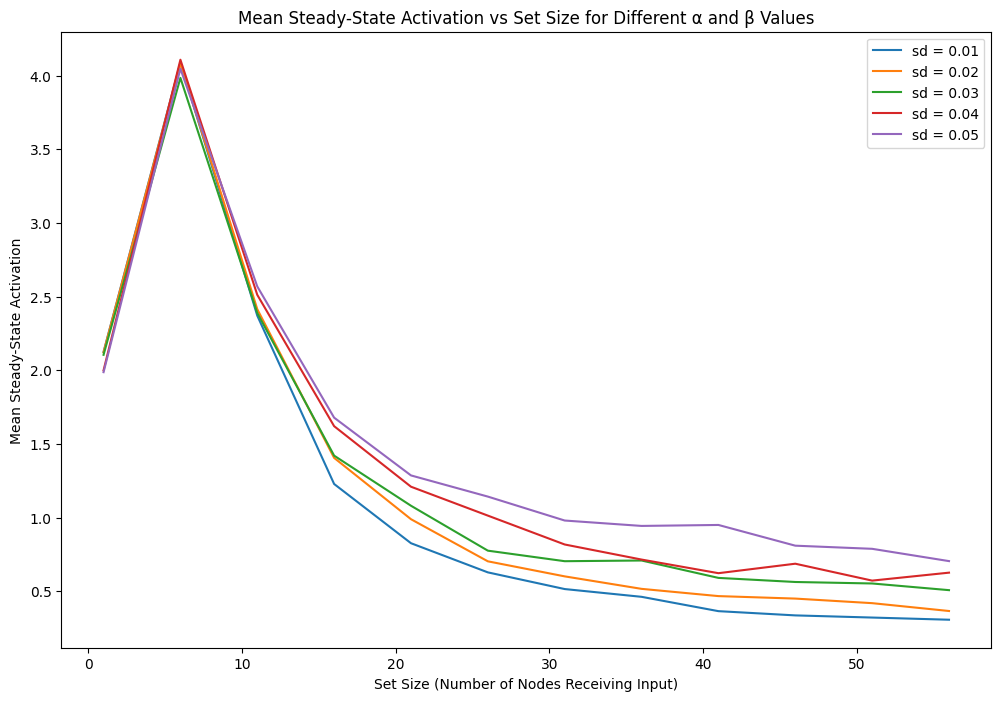

In [ ]:
noises = np.arange(0.01, 0.06, 0.01)
betas = [0.01]
set_sizes = np.arange(1, 61, 5)

plt.figure(figsize=(12, 8))

for noise in noises:
    network = ActivationNetwork(noise_std=noise)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=5)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'sd = {noise}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different α and β Values')
plt.legend()
plt.show()

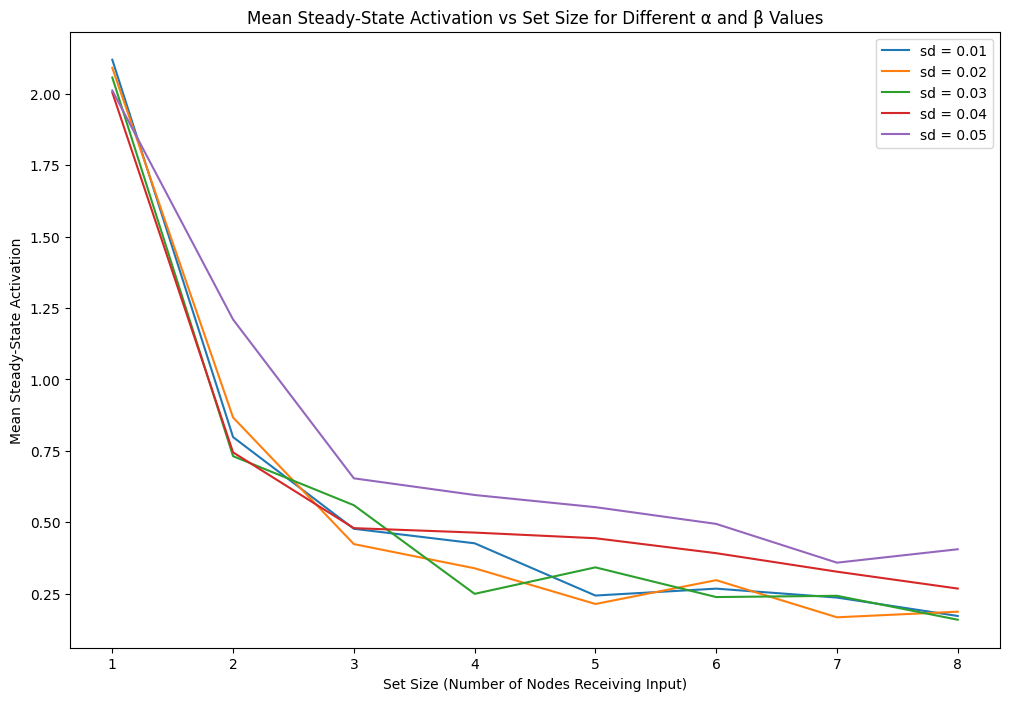

In [ ]:
noises = np.arange(0.01, 0.06, 0.01)
betas = [0.1]
set_sizes = np.arange(1, 9, 1)

plt.figure(figsize=(12, 8))

for noise in noises:
    network = ActivationNetwork(noise_std=noise)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=5)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'sd = {noise}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different α and β Values')
plt.legend()
plt.show()

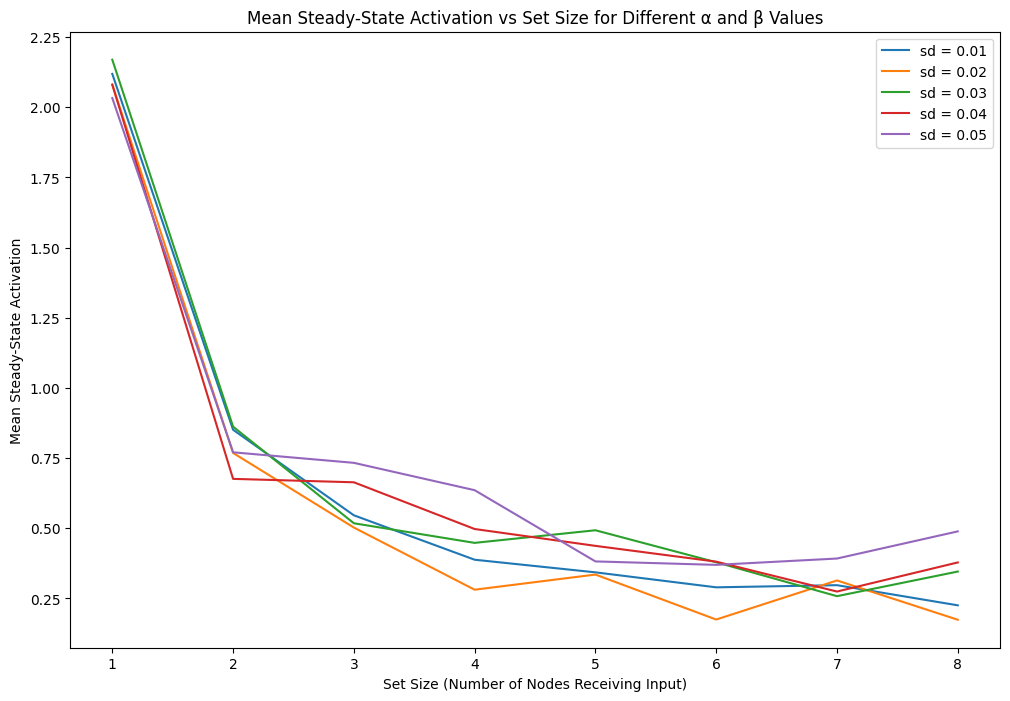

In [ ]:
noises = np.arange(0.01, 0.06, 0.01)
betas = [0.15]
set_sizes = np.arange(1, 9, 1)

plt.figure(figsize=(12, 8))

for noise in noises:
    network = ActivationNetwork(noise_std=noise)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=5)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'sd = {noise}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different α and β Values')
plt.legend()
plt.show()

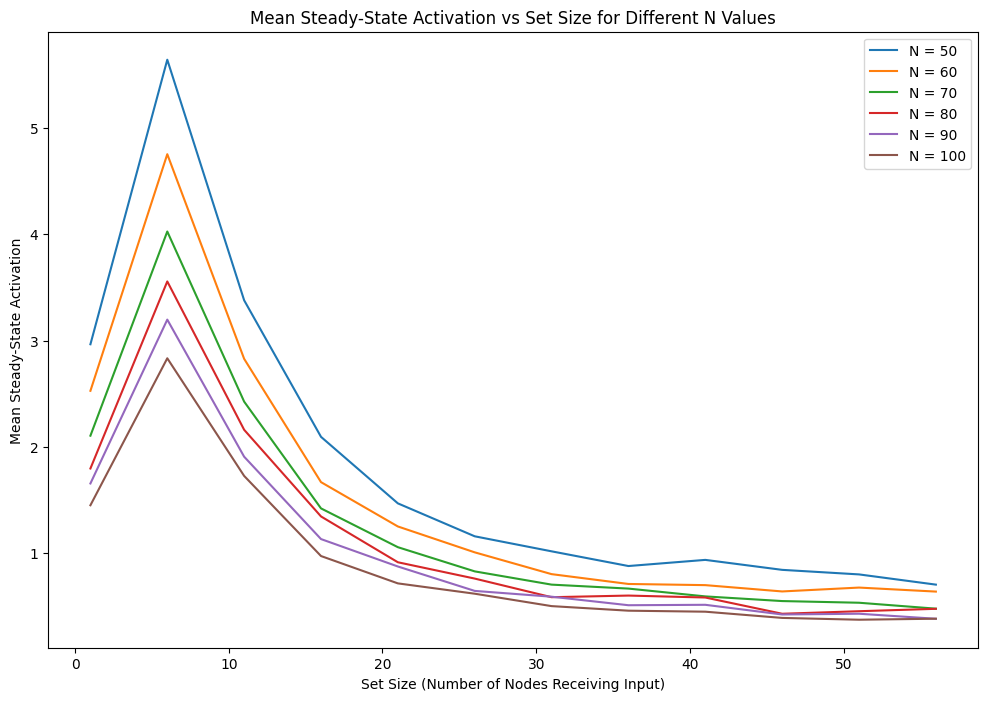

In [29]:
Ns = np.arange(50, 101, 10)
betas = [0.01]
set_sizes = np.arange(1, 61, 5)

plt.figure(figsize=(12, 8))

for N in Ns:
    network = ActivationNetwork(N=N)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=5)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'N = {N}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different N Values')
plt.legend()
plt.show()

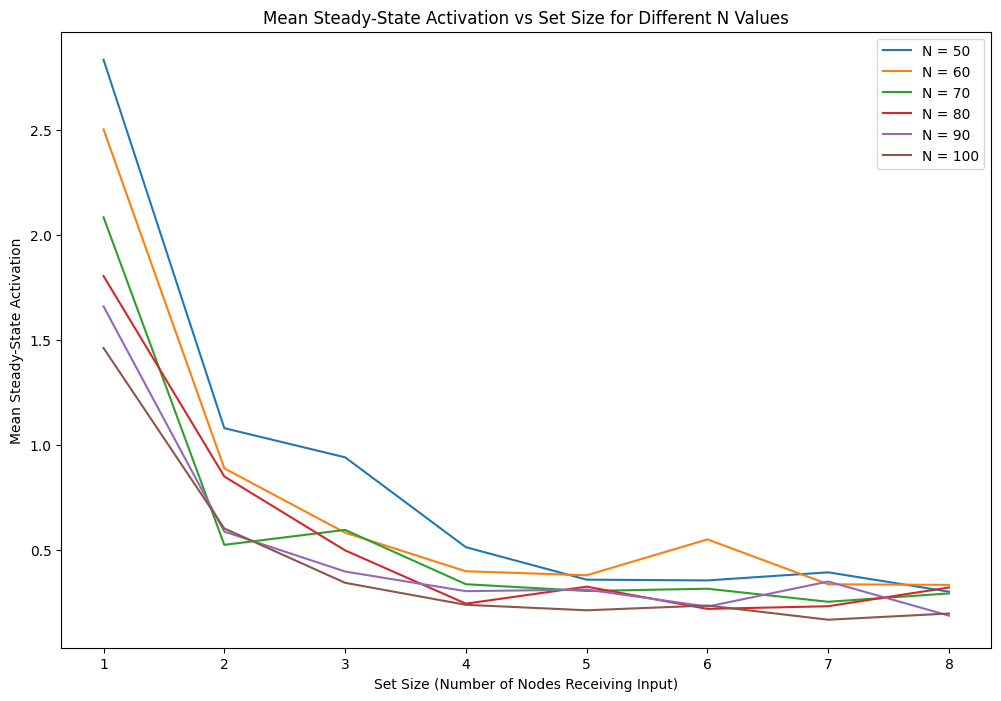

In [30]:
Ns = np.arange(50, 101, 10)
betas = [0.1]
set_sizes = np.arange(1, 9, 1)

plt.figure(figsize=(12, 8))

for N in Ns:
    network = ActivationNetwork(N=N)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=5)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'N = {N}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different N Values')
plt.legend()
plt.show()

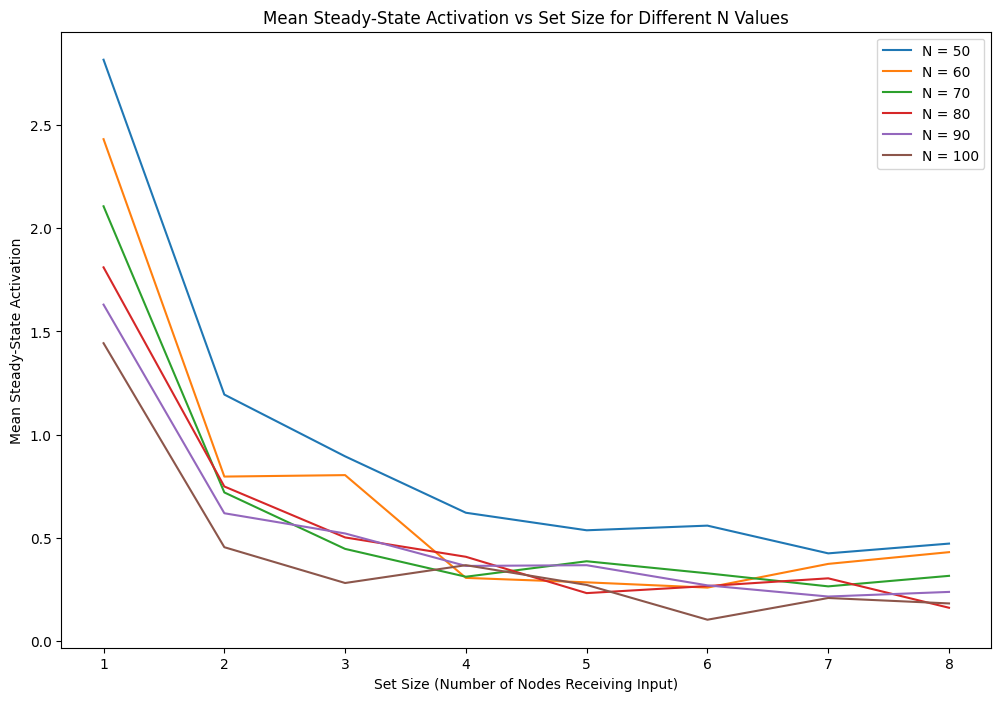

In [31]:
Ns = np.arange(50, 101, 10)
betas = [0.15]
set_sizes = np.arange(1, 9, 1)

plt.figure(figsize=(12, 8))

for N in Ns:
    network = ActivationNetwork(N=N)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=5)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'N = {N}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different N Values')
plt.legend()
plt.show()

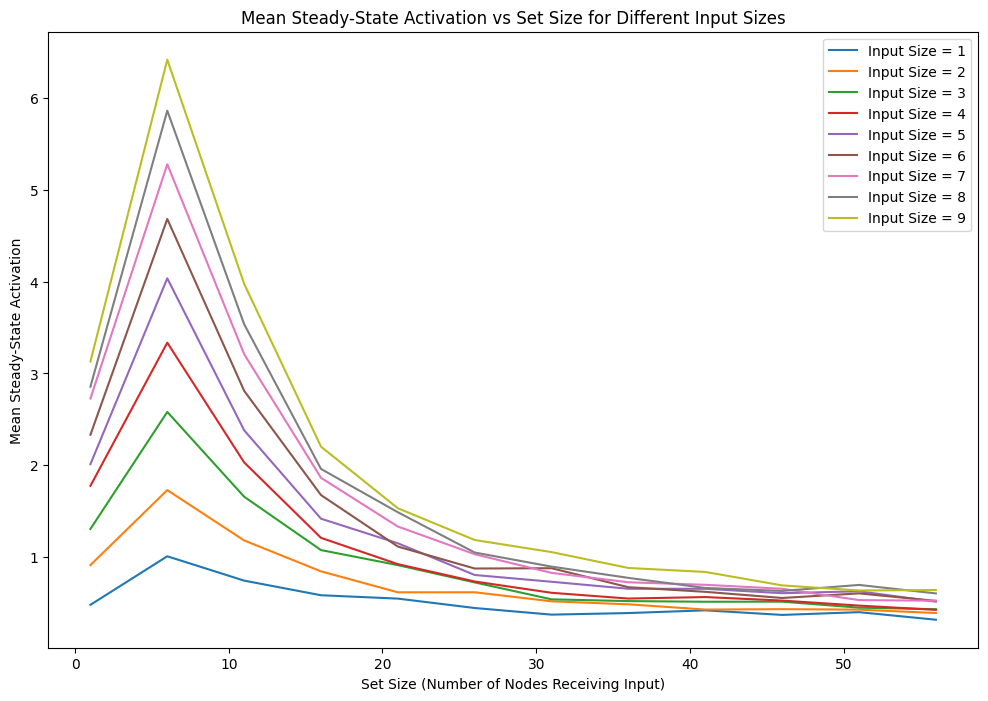

In [32]:
input_sizes = np.arange(1, 10, 1)
betas = [0.01]
set_sizes = np.arange(1, 61, 5)

plt.figure(figsize=(12, 8))

for input_size in input_sizes:
    network = ActivationNetwork(input_size=input_size)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=5)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'Input Size = {input_size}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different Input Sizes')
plt.legend()
plt.show()

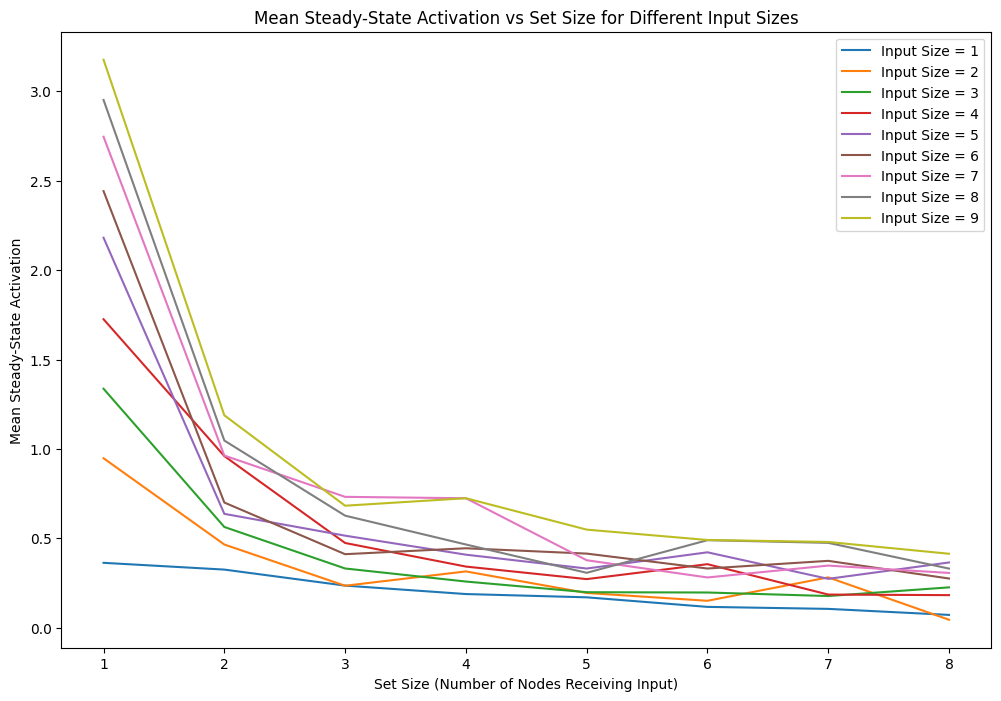

In [33]:
input_sizes = np.arange(1, 10, 1)
betas = [0.1]
set_sizes = np.arange(1, 9, 1)

plt.figure(figsize=(12, 8))

for input_size in input_sizes:
    network = ActivationNetwork(input_size=input_size)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=5)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'Input Size = {input_size}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different Input Sizes')
plt.legend()
plt.show()

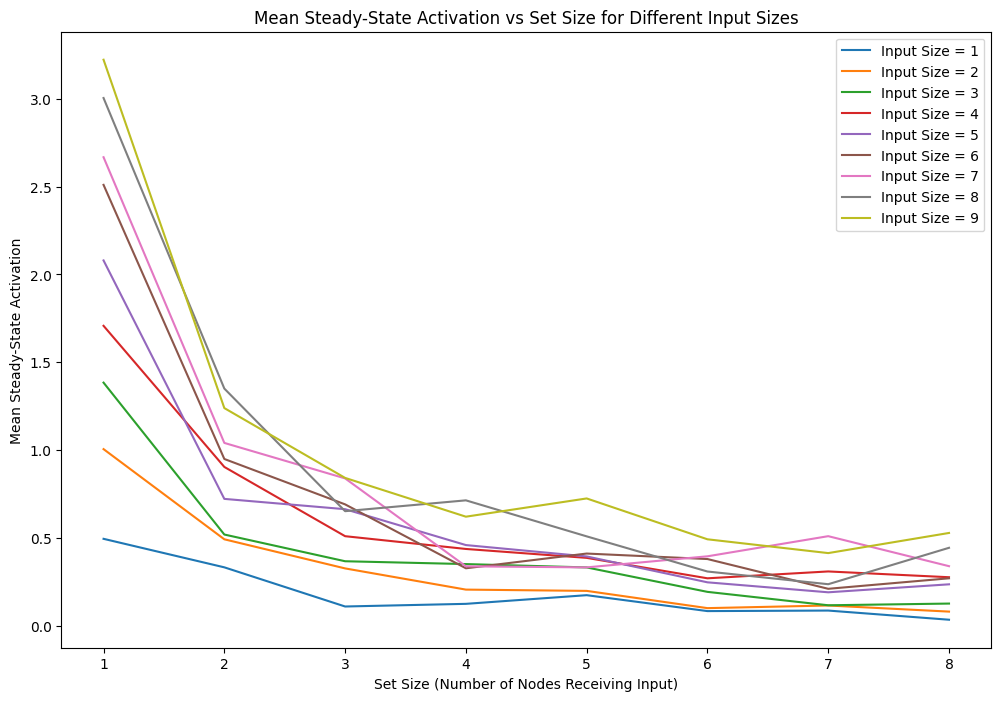

In [34]:
input_sizes = np.arange(1, 10, 1)
betas = [0.15]
set_sizes = np.arange(1, 9, 1)

plt.figure(figsize=(12, 8))

for input_size in input_sizes:
    network = ActivationNetwork(input_size=input_size)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=5)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'Input Size = {input_size}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different Input Sizes')
plt.legend()
plt.show()

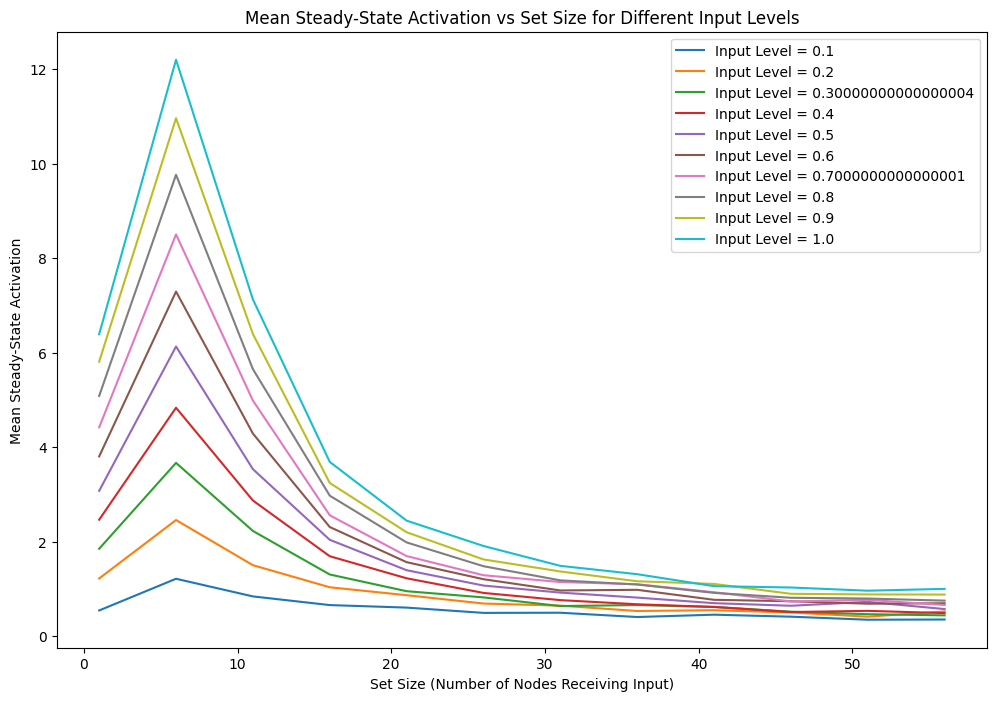

In [35]:
input_levels = np.arange(0.1, 1.1, 0.1)
betas = [0.01]
set_sizes = np.arange(1, 61, 5)

plt.figure(figsize=(12, 8))

for input_level in input_levels:
    network = ActivationNetwork(input_level=input_level)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=5)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'Input Level = {input_level}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different Input Levels')
plt.legend()
plt.show()

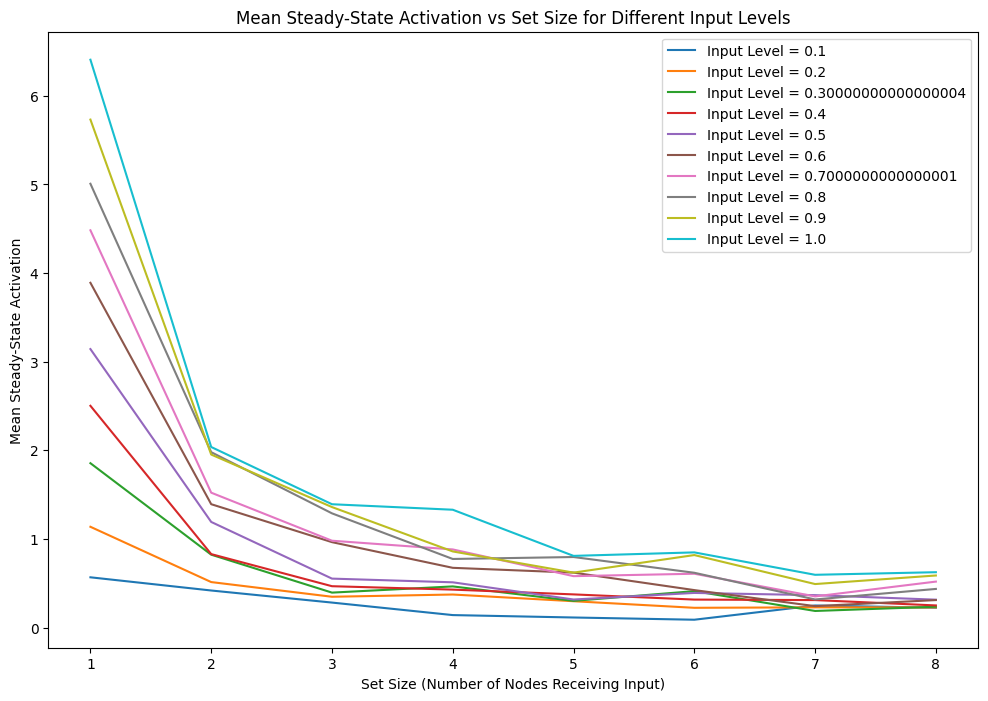

In [36]:
input_levels = np.arange(0.1, 1.1, 0.1)
betas = [0.1]
set_sizes = np.arange(1, 9, 1)

plt.figure(figsize=(12, 8))

for input_level in input_levels:
    network = ActivationNetwork(input_level=input_level)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=5)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'Input Level = {input_level}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different Input Levels')
plt.legend()
plt.show()

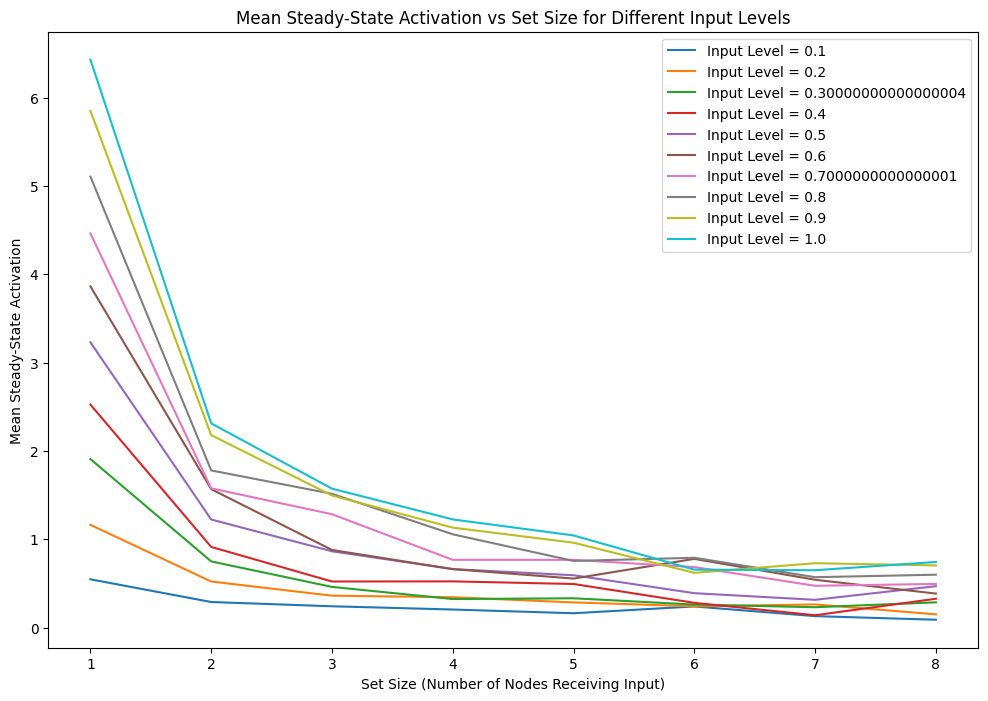

In [37]:
input_levels = np.arange(0.1, 1.1, 0.1)
betas = [0.15]
set_sizes = np.arange(1, 9, 1)

plt.figure(figsize=(12, 8))

for input_level in input_levels:
    network = ActivationNetwork(input_level=input_level)
    mean_activations = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_activations[i, j] = network.find_mean_activation(beta, set_size, num_simulations=5)

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_activations[i, :], label=f'Input Level = {input_level}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Mean Steady-State Activation')
plt.title('Mean Steady-State Activation vs Set Size for Different Input Levels')
plt.legend()
plt.show()

# SOA PLOT

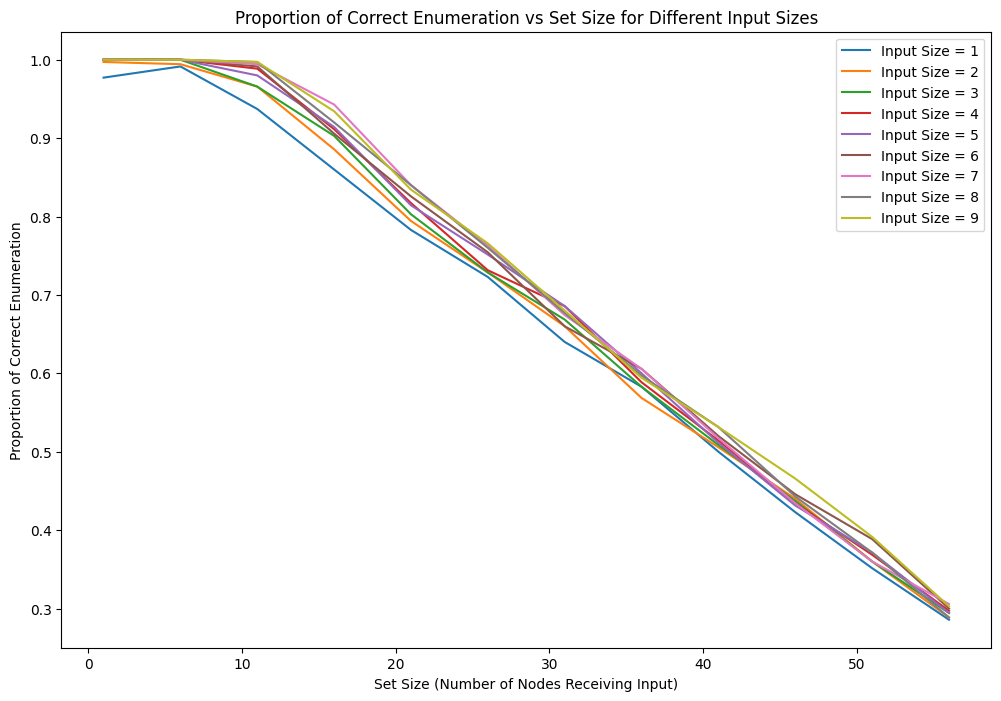

In [38]:
input_sizes = np.arange(1, 10, 1)
betas = [0.01]
set_sizes = np.arange(1, 61, 5)

plt.figure(figsize=(12, 8))

for input_size in input_sizes:
    network = ActivationNetwork(input_size=input_size)
    mean_correct_enumeration = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_correct_enumeration[i, j] = 1 - network.find_mean_hamming_distance(beta, set_size, num_simulations=5) / network.N

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_correct_enumeration[i, :], label=f'Input Size = {input_size}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Proportion of Correct Enumeration')
plt.title('Proportion of Correct Enumeration vs Set Size for Different Input Sizes')
plt.legend()
plt.show()

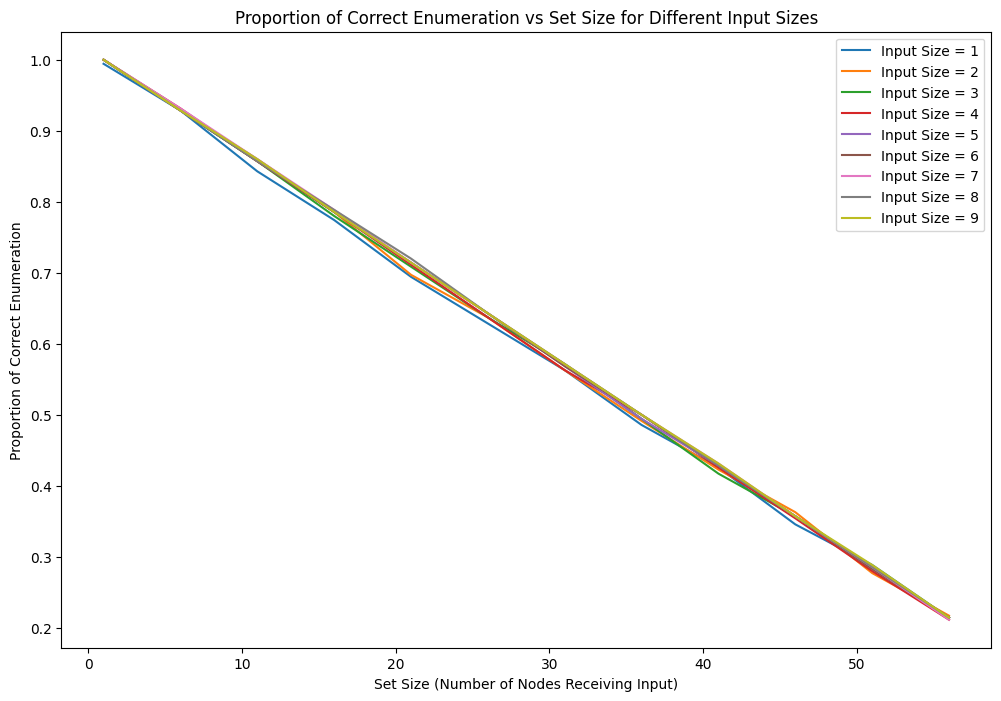

In [39]:
input_sizes = np.arange(1, 10, 1)
betas = [0.1]
set_sizes = np.arange(1, 61, 5)

plt.figure(figsize=(12, 8))

for input_size in input_sizes:
    network = ActivationNetwork(input_size=input_size)
    mean_correct_enumeration = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_correct_enumeration[i, j] = 1 - network.find_mean_hamming_distance(beta, set_size, num_simulations=5) / network.N

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_correct_enumeration[i, :], label=f'Input Size = {input_size}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Proportion of Correct Enumeration')
plt.title('Proportion of Correct Enumeration vs Set Size for Different Input Sizes')
plt.legend()
plt.show()

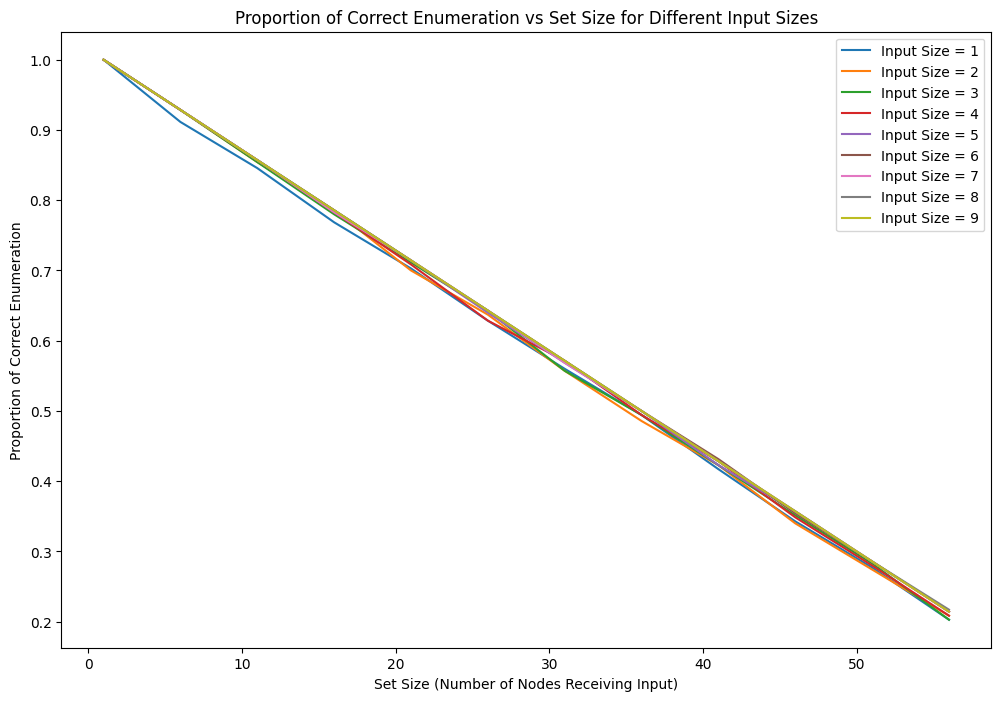

In [40]:
input_sizes = np.arange(1, 10, 1)
betas = [0.15]
set_sizes = np.arange(1, 61, 5)

plt.figure(figsize=(12, 8))

for input_size in input_sizes:
    network = ActivationNetwork(input_size=input_size)
    mean_correct_enumeration = np.zeros((len(betas), len(set_sizes)))

    for i, beta in enumerate(betas):
        for j, set_size in enumerate(set_sizes):
            mean_correct_enumeration[i, j] = 1 - network.find_mean_hamming_distance(beta, set_size, num_simulations=5) / network.N

    for i, beta in enumerate(betas):
        plt.plot(set_sizes, mean_correct_enumeration[i, :], label=f'Input Size = {input_size}')

plt.xlabel('Set Size (Number of Nodes Receiving Input)')
plt.ylabel('Proportion of Correct Enumeration')
plt.title('Proportion of Correct Enumeration vs Set Size for Different Input Sizes')
plt.legend()
plt.show()